# 실습 4: 개 vs 고양이 (전이학습)

**목표**: ResNet50 전이학습으로 95%+ 달성

**도전**: 본인 사진으로 테스트!

---

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt

## Step 1: 데이터 준비

Oxford-IIIT Pet 데이터셋 사용 (개 vs 고양이)

In [2]:
import tensorflow_datasets as tfds

# Oxford Pets 데이터셋 로드
ds, ds_info = tfds.load(
    'oxford_iiit_pet',
    split='train',
    with_info=True
)

# 개(0) vs 고양이(1) 라벨 만들기
# oxford_iiit_pet은 species: 0=고양이, 1=개
def extract_image_label(example):
    image = example['image']
    label = example['species']  # 0=cat, 1=dog
    return image, label

ds = ds.map(extract_image_label)

# train/test 분리
total = tf.data.experimental.cardinality(ds).numpy()
train_size = int(total * 0.8)

ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)

print(f"학습 데이터: {train_size}개")
print(f"테스트 데이터: {total - train_size}개")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.MMGMJC_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.MMGMJC_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
학습 데이터: 2944개
테스트 데이터: 736개


In [3]:
# 이미지 전처리 함수
IMG_SIZE = 224  # ResNet 입력 크기

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# 데이터 파이프라인
BATCH_SIZE = 32

train_ds = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

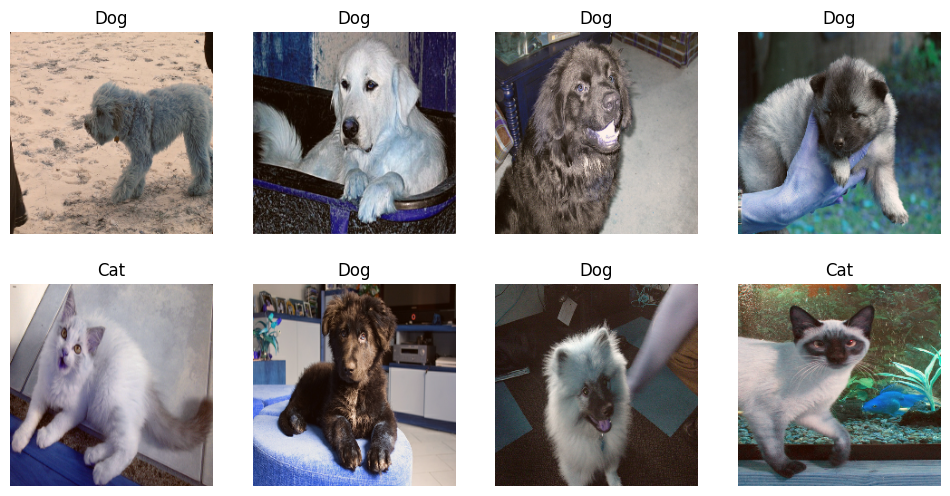

In [4]:
# 샘플 확인
for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = images[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.set_title('Cat' if labels[i] == 0 else 'Dog')
        ax.axis('off')
    plt.show()

## Step 2: 전이학습 모델

In [5]:
# ResNet50 불러오기 (ImageNet 가중치, 상단 제외)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 기본 모델 동결 (가중치 고정)
base_model.trainable = False

print(f"ResNet50 레이어 수: {len(base_model.layers)}")
print(f"학습 가능 파라미터: {sum([tf.reduce_prod(v.shape) for v in base_model.trainable_weights])}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet50 레이어 수: 175
학습 가능 파라미터: 0


In [6]:
# 전체 모델 구성
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Step 3: 학습

In [7]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - accuracy: 0.8991 - loss: 0.2476 - val_accuracy: 0.9918 - val_loss: 0.0252
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.9948 - loss: 0.0169 - val_accuracy: 0.9918 - val_loss: 0.0250
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.9935 - loss: 0.0187 - val_accuracy: 0.9905 - val_loss: 0.0275
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 228ms/step - accuracy: 0.9940 - loss: 0.0140 - val_accuracy: 0.9918 - val_loss: 0.0213
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.9982 - loss: 0.0048 - val_accuracy: 0.9932 - val_loss: 0.0255


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


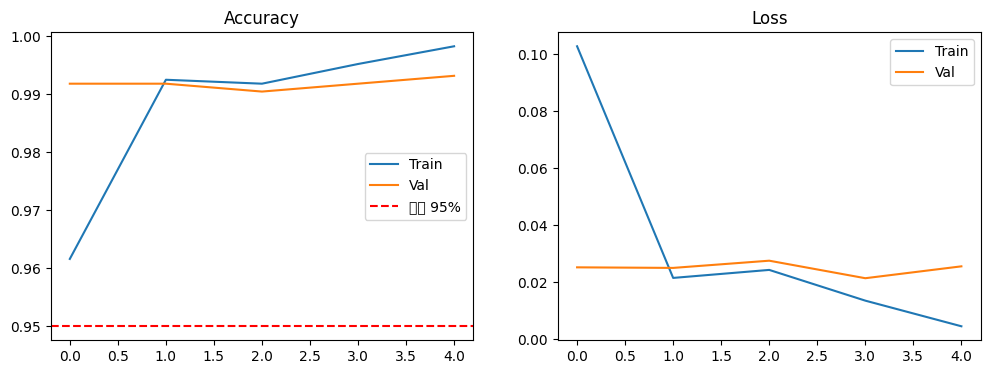

In [8]:
# 학습 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='목표 95%')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
plt.show()

## Step 4: 평가

In [9]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n테스트 정확도: {test_acc:.2%}")

if test_acc >= 0.95:
    print("95% 달성!")
else:
    print(f"Fine-tuning으로 더 높일 수 있습니다.")


테스트 정확도: 99.32%
95% 달성!


## 본인 이미지로 테스트!

In [14]:
from google.colab import files
from PIL import Image
import io

def predict_image(image_path):
    # 이미지 로드 및 전처리
    img = keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # 예측
    prediction = model.predict(img_array)[0][0]

    # 결과 출력
    plt.figure(figsize=(6, 6))
    plt.imshow(keras.preprocessing.image.load_img(image_path))

    if prediction > 0.5:
        result = f"1 ({prediction:.1%})"
    else:
        result = f"2 ({1-prediction:.1%})"

    plt.title(f"예측: {result}", fontsize=16)
    plt.axis('off')
    plt.show()

print("아래 셀에서 이미지를 업로드하세요!")

아래 셀에서 이미지를 업로드하세요!


Saving 1.jpeg to 1 (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


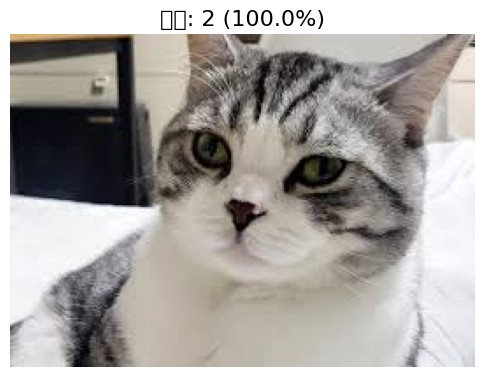

In [15]:
# 이미지 업로드
uploaded = files.upload()

for filename in uploaded.keys():
    predict_image(filename)

---
## 완료!

전이학습의 장점:
1. **적은 데이터**로 높은 성능
2. **빠른 학습** (사전학습 가중치 활용)
3. **검증된 구조** (ImageNet에서 검증됨)

실제 프로젝트에서는 전이학습을 먼저 시도하세요!